## Portfolio Luck Analyzer

This exercise is to evaluate how lucky I am currently with the current portfolio, and how lucky I have been since I started investing.
"Lucky" is all relative and it refers in which percentile I am compared to 20+ years time series of MSCI ACWI, as a benchmark for Worldwide stock index (in lieu of VWCE), and IEF (iShares 7-10 Year Treasury Bond ETF), as a benchmark for investment grade government bonds (in lieu of AGGH).
Yeah yeah, these indices are USD-nominated and not fully aligned with my VWCE/AGGH, however these are some of the few benchmarks with such a long history and the EUR/USD exchange rate should not change so much in the long term.

The ACWI&IEF time series is analyzed in detail in the "Time Series Analysis" notebook.

In [1]:
from datetime import date
import polars as pl
import polars.selectors as cs
import numpy as np
import scipy.stats as ss
import yfinance as yf
from matplotlib import pyplot as plt
import ipywidgets as widgets
from IPython.display import display

In [2]:
#set parameters
end_date = date.today()

#obtain market benchmark data
mkt=pl.read_excel("TimeSeries_luck.xlsx",sheet_name="Market")
mkt=mkt.with_columns((mkt["Date"].str.to_date("%Y-%m-%d")).alias("Date"))
dist=mkt.to_numpy()
dist = np.delete(dist,0,1)
mkt.head(5)

Date,IEF_change,ACWI_change
date,f64,f64
2002-09-01,0.034988,-0.109683
2002-10-01,-0.012032,0.073638
2002-11-01,-0.02136,0.054702
2002-12-01,0.02765,-0.047677
2003-01-01,0.003331,-0.029187


In [3]:
#obtain my portfolio data
tickers=["AGGH","VWCE"] # AGGH in first place because IEF is in first place (bond ETF)
tickers_dl=["AGGH.MI","VWCE.MI"]
pf=pl.read_excel("TimeSeries_luck.xlsx",sheet_name="MyPortfolio")
pf=pf.with_columns((pf["Date"].str.to_date("%m-%d-%y")).alias("Date"))
pf

Date,Ticker,# shares,Price,Purchased value
date,str,i64,f64,f64
2022-01-17,"""VWCE""",19,102.23,1942.37
2022-01-17,"""AGGH""",283,5.181,1466.223
2022-05-02,"""VWCE""",20,98.06,1961.2
2022-05-02,"""AGGH""",242,4.832,1169.344
2022-09-19,"""VWCE""",15,94.61,1419.15
2022-09-19,"""AGGH""",223,4.63,1032.49
2022-12-06,"""VWCE""",12,94.65,1135.8
2023-03-13,"""VWCE""",17,92.22,1567.74
2023-04-14,"""AGGH""",178,4.6375,825.475


## Transform portfolio data

In [4]:
# transform my portfolio data

# 1. put 1 row for each date - data to keep: Purchased value, quantity purchased
pf_value = pf.pivot(index="Date",columns="Ticker", values="Purchased value", aggregate_function="sum").fill_null(0)
pf_qty = pf.pivot(index="Date",columns="Ticker", values="# shares", aggregate_function="sum").fill_null(0)
pf_worked = pf_value.join(pf_qty, on="Date",suffix="_qty")

# 2. rework to obtain 1 row per month (from market I obtained monthly returns)
pf_worked = pf_worked.with_columns(pl.concat_str([
                                                    pl.col("Date").dt.year(),
                                                    pl.col("Date").dt.month()],
                                                    separator="-").alias("year-month"))
pf_worked=pf_worked.with_columns((pl.col("year-month")+"-1").alias("year-month"))
pf_worked=pf_worked.with_columns((pf_worked["year-month"].str.to_date("%Y-%m-%d")).alias("year-month"))
pf_worked=pf_worked.group_by("year-month",maintain_order=True).agg(cs.numeric().sum())
pf_worked

year-month,VWCE,AGGH,VWCE_qty,AGGH_qty
date,f64,f64,i64,i64
2022-01-01,1942.37,1466.223,19,283
2022-05-01,1961.2,1169.344,20,242
2022-09-01,1419.15,1032.49,15,223
2022-12-01,1135.8,0.0,12,0
2023-03-01,1567.74,0.0,17,0
2023-04-01,0.0,825.475,0,178
2023-06-01,1479.3,621.4725,15,135
2023-07-01,1417.64,510.8775,14,111
2023-08-01,2406.48,0.0,24,0


In [5]:
# 3. add weighted prices per month
pf_col=pf_worked.columns
x=list(range(int((len(pf_col)-1)/2)))
pf_prices=pf_worked
for i in x:
    pf_prices=pf_prices.with_columns((pl.col(pf_col[i+1])/pl.col(pf_col[i+3])).alias(pf_col[i+1]+"_price")).fill_nan(0)
pf_prices

year-month,VWCE,AGGH,VWCE_qty,AGGH_qty,VWCE_price,AGGH_price
date,f64,f64,i64,i64,f64,f64
2022-01-01,1942.37,1466.223,19,283,102.23,5.181
2022-05-01,1961.2,1169.344,20,242,98.06,4.832
2022-09-01,1419.15,1032.49,15,223,94.61,4.63
2022-12-01,1135.8,0.0,12,0,94.65,0.0
2023-03-01,1567.74,0.0,17,0,92.22,0.0
2023-04-01,0.0,825.475,0,178,0.0,4.6375
2023-06-01,1479.3,621.4725,15,135,98.62,4.6035
2023-07-01,1417.64,510.8775,14,111,101.26,4.6025
2023-08-01,2406.48,0.0,24,0,100.27,0.0


In [6]:
# 3. cumulated sum
pf_cumul=pf_worked.select(["year-month",cs.numeric().cum_sum()])
pf_cumul

year-month,VWCE,AGGH,VWCE_qty,AGGH_qty
date,f64,f64,i64,i64
2022-01-01,1942.37,1466.223,19,283
2022-05-01,3903.57,2635.567,39,525
2022-09-01,5322.72,3668.057,54,748
2022-12-01,6458.52,3668.057,66,748
2023-03-01,8026.26,3668.057,83,748
2023-04-01,8026.26,4493.532,83,926
2023-06-01,9505.56,5115.0045,98,1061
2023-07-01,10923.2,5625.882,112,1172
2023-08-01,13329.68,5625.882,136,1172


In [7]:
# 4. upsample to include missing months
pf_prices=pf_prices.set_sorted("year-month")
pf_cumul=pf_cumul.set_sorted("year-month")
pf_prices=pf_prices.upsample(time_column="year-month",every="1mo").fill_null(0)
pf_cumul=pf_cumul.upsample(time_column="year-month",every="1mo").select(pl.all().forward_fill())
for i in x:
    pf_cumul=pf_cumul.with_columns((pl.col(pf_col[i+1])/pl.col(pf_col[i+3])).alias(pf_col[i+1]+"_weighted_price"))
pf_cumul.tail(5)

year-month,VWCE,AGGH,VWCE_qty,AGGH_qty,VWCE_weighted_price,AGGH_weighted_price
date,f64,f64,i64,i64,f64,f64
2023-12-01,20580.23,6975.9405,207,1466,99.421401,4.758486
2024-01-01,21762.4,8078.7825,218,1700,99.827523,4.752225
2024-02-01,22891.1,8078.7825,228,1700,100.399561,4.752225
2024-03-01,22891.1,8078.7825,228,1700,100.399561,4.752225
2024-04-01,24519.58,8078.7825,242,1700,101.320579,4.752225


In [8]:
# download the tickers performance in my reference period
start_df = pf_prices.select(["year-month"]).min()
start = start_df.item(0,0)
df=yf.download(tickers_dl,start=start,end=end_date,interval="1mo")['Adj Close']
df=pl.from_pandas(df,include_index=True)
df=df.cast({"Date":pl.Date})
df_show=pl.concat([df.head(5),df.tail(5)],how='vertical')
df_show

[*********************100%%**********************]  2 of 2 completed


Date,AGGH.MI,VWCE.MI
date,f64,f64
2022-01-01,5.156,99.629997
2022-02-01,5.085,97.800003
2022-03-01,4.982,101.75
2022-04-01,4.8325,99.239998
2022-05-01,4.816,96.209999
2024-02-01,4.6875,114.209999
2024-03-01,4.722,118.269997
2024-04-01,4.6425,116.239998
2024-05-01,4.669,117.519997


In [9]:
# combine all in the same df
pf_all=pf_prices.clone()
pf_all=pf_all.join(df,left_on="year-month",right_on="Date",how='outer').fill_null(0)
pf_all=pf_all.join(pf_cumul,left_on="Date",right_on="year-month",how='outer').select(pl.all().forward_fill())
pf_all=pf_all.drop(["year-month","year-month_right"])

# move "Date" to the beginning
pf_all_col=pf_all.columns
pf_all_col.insert(0, "Date")
pf_all_col.pop(7)
pf_all=pf_all.select(pf_all_col)

#rename columns to more meaningful headers
headers={}
for t in tickers:
    purch_value=t+"_purchased"
    price=t+"_price"
    purch_price=t+"_purch_price"
    mkt_price=t+".MI"
    mkt_value=t+"_mkt_val"
    right=t+"_right"
    cum_purch_value=t+"_cpurchased"
    qty_right=t+"_qty_right"
    qty_cumul=t+"_cqty"
    headers[t]=purch_value
    headers[price]=purch_price
    headers[mkt_price]=mkt_value
    headers[right]=cum_purch_value
    headers[qty_right]=qty_cumul
pf_all=pf_all.rename(headers)
pf_all.head(1)

Date,VWCE_purchased,AGGH_purchased,VWCE_qty,AGGH_qty,VWCE_purch_price,AGGH_purch_price,AGGH_mkt_val,VWCE_mkt_val,VWCE_cpurchased,AGGH_cpurchased,VWCE_cqty,AGGH_cqty,VWCE_weighted_price,AGGH_weighted_price
date,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,i64,i64,f64,f64
2022-01-01,1942.37,1466.223,19,283,102.23,5.181,5.156,99.629997,1942.37,1466.223,19,283,102.23,5.181


In [10]:
# further adjustments: 
# (1) if an asset is purchased in the period, mkt_value = purch_price; 
# (2) add pct_change for "mkt_value"
pf=pf_all.clone()
for t in tickers:
    pf=pf.with_columns(pl.when(pl.col(t+"_purch_price") > 0).then(pl.col(t+"_purch_price")).otherwise(pl.col(t+"_mkt_val")).alias(t+"_mkt_val"))
    # this is the value to compare with the simulation, based on the ageing (in months) we will calculate in the next cell
    pf=pf.with_columns((1+(pl.col(t+"_mkt_val")-pl.col(t+"_weighted_price"))/pl.col(t+"_weighted_price")).alias(t+"_%change_vs_purch"))
pf.head(1)

Date,VWCE_purchased,AGGH_purchased,VWCE_qty,AGGH_qty,VWCE_purch_price,AGGH_purch_price,AGGH_mkt_val,VWCE_mkt_val,VWCE_cpurchased,AGGH_cpurchased,VWCE_cqty,AGGH_cqty,VWCE_weighted_price,AGGH_weighted_price,AGGH_%change_vs_purch,VWCE_%change_vs_purch
date,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64
2022-01-01,1942.37,1466.223,19,283,102.23,5.181,5.181,102.23,1942.37,1466.223,19,283,102.23,5.181,1.0,1.0


In [11]:
# (3) calculate weighted average ageing for each asset at each point in time - this is a bit of a pain in the ass
x=range(0,len(pf))
months=list(x)
df=pf.select(["Date"])
m=pl.Series("month",months)
df.insert_column(0,m)

for t in tickers:
    col=pf.select([t+"_qty"]).to_series()
    df.insert_column(-1,col)
arr=df.to_numpy()
for t in range(1,len(tickers)+1): # check for every ticker
    sum_prod = np.zeros([len(months),len(months)])
    sum_ = np.zeros([len(months),len(months)])
    count_ = np.zeros([len(months),len(months)])
    for j in x: #check on all the time periods
        qty = arr[j,t]
        count=1
        if qty>0:
            for i in x:
                if i>j:
                    sum_prod[i,j]=qty*(i-j)
                    sum_[i,j]=qty
                    count_[i,j]=count
                    count+=1
    sum_prod_res = sum_prod.sum(axis=1)
    sum_res = sum_.sum(axis=1)
    np.seterr(divide='ignore')
    age=sum_prod_res/sum_res
    age=np.nan_to_num(age,nan=0).astype(np.int32)
    l=pl.Series(tickers[t-1]+"_age",age.tolist())
    pf.insert_column(-1,l)
pf.tail(1)

C:\Users\mbolo\AppData\Local\Temp\ipykernel_12244\1674165539.py:29: RuntimeWarning: invalid value encountered in divide
  age=sum_prod_res/sum_res


Date,VWCE_purchased,AGGH_purchased,VWCE_qty,AGGH_qty,VWCE_purch_price,AGGH_purch_price,AGGH_mkt_val,VWCE_mkt_val,VWCE_cpurchased,AGGH_cpurchased,VWCE_cqty,AGGH_cqty,VWCE_weighted_price,AGGH_weighted_price,AGGH_%change_vs_purch,AGGH_age,VWCE_age,VWCE_%change_vs_purch
date,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,i64,i64,f64,f64,f64,i64,i64,f64
2024-06-01,0.0,0.0,0,0,0.0,0.0,4.684,118.379997,24519.58,8078.7825,242,1700,101.320579,4.752225,0.985644,16,12,1.168371


# Run simulations and assess your luck

In [12]:
# run simulations
def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

n_var=len(tickers)
n_runs=10000
n_periods =  diff_month(end_date,start) # periods of investment horizon
print("Nr. months: ",n_periods)

tot = n_var*n_runs*n_periods
seed = 1231231 # seed of random uniform distribution
random_space = ss.uniform.rvs(size=tot, random_state=seed)
random_space = random_space.reshape(n_periods, n_var, n_runs)

#run the simulation - assuming no correlation between variables

ones = np.ones([n_periods, n_var])
rand_walks = np.zeros([n_periods,n_var, n_runs])

#progress bar setup
f = widgets.IntProgress(min=0, max=n_runs,description='Simulation:',) # instantiate the bar
display(f) # display the bar

for run in range(n_runs):
    if run%100==0:
        f.value = run
    pc_change = np.zeros([n_periods, n_var])
    for var in range(n_var):
        rspace = random_space[:,var,run]
        pc_change[:,var] = np.quantile(dist[:,var],rspace)
    pc_change = pc_change+ones
    pc_change = np.cumprod(pc_change,axis=0)
    rand_walks[:,:,run] = pc_change[:,:]

Nr. months:  29


IntProgress(value=0, description='Simulation:', max=10000)

In [13]:
# select the filter with the relevant data for the quantile calculation
column_list=["Date"] # columns to be taken from pf DataFrame
for t in tickers:
    column_list.append(t+"_%change_vs_purch")
    column_list.append(t+"_age")
quant=pf.select(column_list)
quant=quant.filter(pl.col("Date")>start)
quant

Date,AGGH_%change_vs_purch,AGGH_age,VWCE_%change_vs_purch,VWCE_age
date,f64,i64,f64,i64
2022-02-01,0.981471,1,0.956666,1
2022-03-01,0.96159,2,0.995305,2
2022-04-01,0.932735,3,0.970752,3
2022-05-01,0.962525,4,0.979703,4
2022-06-01,0.942805,3,0.904472,2
2022-07-01,0.970493,4,0.984599,3
2022-08-01,0.937028,5,0.970112,4
2022-09-01,0.944162,6,0.959836,5
2022-10-01,0.920405,5,0.959431,5


In [14]:
# calculate the quantile for each asset at each period

for var in range(n_var):
    l=quant.columns
    t = tickers[var]
    a=[item for item in l if t in item]
    ticker_input=quant.select(a).to_numpy()
    l=[]
    p20=[]
    for p in range(len(quant)):
        result=ticker_input[p,0]
        age=int(ticker_input[p,1])-1 # -1 because simulation period 0 is actually equivalent to ageing=1
        # distribution of 10,000 results at time = age and var corresponding to the ticker
        ref_dist= rand_walks[age,var,:]
        l.append((ref_dist<=result).sum()/n_runs)
        p20.append(np.quantile(ref_dist,0.2))
    ls=pl.Series(t+"_prob",l)
    p20=pl.Series(t+"_p20",p20)
    quant.insert_column(-1,ls)
    quant.insert_column(-1,p20)
quant.tail(1)

Date,AGGH_%change_vs_purch,AGGH_age,VWCE_%change_vs_purch,AGGH_prob,AGGH_p20,VWCE_prob,VWCE_p20,VWCE_age
date,f64,i64,f64,f64,f64,f64,f64,i64
2024-06-01,0.985644,16,1.168371,0.2103,0.983259,0.6631,0.964268,12


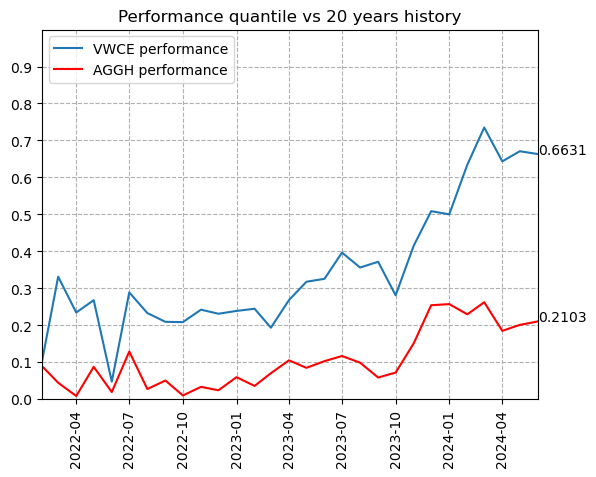

In [15]:
# let's plot!

date=quant.select("Date").to_numpy().reshape(-1)
VWCE_perf=quant.select("VWCE_prob").to_numpy().reshape(-1)
VWCE_p20=quant.select("VWCE_p20").to_numpy().reshape(-1)
AGGH_perf=quant.select("AGGH_prob").to_numpy().reshape(-1)
AGGH_p20=quant.select("AGGH_p20").to_numpy().reshape(-1)

ax = plt.gca()
ax.set_xlim([date[0], date[-1]])
ax.set_yticks(np.arange(0, 1, 0.1))
ax.set_ylim([0,1])
plt.plot(date,VWCE_perf,label="VWCE performance")
plt.plot(date,AGGH_perf, label="AGGH performance", color='r')
plt.legend(loc="upper left")
plt.title(label="Performance quantile vs 20 years history")
plt.xticks(rotation=90)
VWCE_last = VWCE_perf[-1]
AGGH_last = AGGH_perf[-1]
xyVW = (date[-1],VWCE_last)
xyAG = (date[-1],AGGH_last)
plt.annotate(VWCE_last,xyVW)
plt.annotate(AGGH_last,xyAG)
plt.grid(linestyle='--')
plt.show()

## A few comments after this nice plot

In the example, I can say that as of June 2024:
- my VWCE was performing better than 66% (about 2/3) of the simulations performed, at weighted ageing = 12 months;
- my AGGH was performing better than 21% (about 1/5) of the simulations performed, at weighted ageing = 16 months.

Therefore, psychologically I am aware that I am on an average luck streak. Bond ETFs have endured a shitty 2022 due to the interest rate hikes, something that IEF did not suffer so bad in 20+ years (probability of doing worse was 1% in October 2023),but they did recover a bit towards the end of 2023.
Stock ETFs have had a bad 2022 as well, however from December 2023 I cannot complain: I would have performed worse in more than 50% of the cases.

## Finding a more stable evaluation of net worth?

A lot of people on "personal finance" forums/subreddits seem very keen on measuring their net worth on a daily basis, monitoring every slight stock price movement in their shiny spreadsheets. On the contrary, in my books all my holdings are written at purchase price and I considered to keep it that way till the end of time, but even this approach wouldn't allow me and my wife to fully appreciate why we are putting our savings in this treasure chest under the sand, instead of enjoying a vacation on a sandy beach. 

This "luck analyzer" allows me to understand what could be a fairer value of my investments - a middle point between mark-to-market and historical purchasing price. 

For example, being a very cautious person, I could put my fair value at the 20%-percentile (p20), i.e. I would have 80% probability not to expect a price decrease of my holdings.

As of June 2024, this would mean that I should put the fair value of my VWCE holdings at 96.4% of their weighted average purchasing price. p20 would reach parity with the weighted purchasing price at around ageing equal to 25/26 months.